# Create a forward operator and display sensitivity maps

`
Authors: Eric Larson <larson.eric.d@gmail.com>
         Denis Engemann <denis.engemann@gmail.com>
         Alex Gramfort <alexandre.gramfort@inria.fr>
`

License: BSD (3-clause)

First setup some paths. We will use the MNE sample data.

In [11]:
%matplotlib qt
import matplotlib.pyplot as plt

import os
import mne

# Change the following path to where the folder ds000117-practical is on your disk
data_path = os.path.expanduser("~/work/data/ds000117-practical/")

raw_fname = os.path.join(data_path,
    'derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif')

In [2]:
from IPython.display import Image
from mayavi import mlab

In [5]:
# to check that things work:
mlab.test_contour3d()
mlab.show()

# Computing the forward operator

To compute a forward operator we need:

   - a ``-trans.fif`` file that contains the coregistration info
   - a source space
   - the BEM surfaces

## Compute and visualize BEM surfaces

Computing the BEM surfaces requires FreeSurfer and makes use of either of the two following command line tools:

[mne watershed_bem](http://martinos.org/mne/dev/generated/commands.html#mne-watershed-bem)

[mne flash_bem](http://martinos.org/mne/dev/generated/commands.html#mne-flash-bem)

or directly by calling the functions

https://mne.tools/stable/generated/mne.bem.make_watershed_bem.html
https://mne.tools/stable/generated/mne.bem.make_flash_bem.html

Here, we'll assume it's already computed. It takes a few minutes per subject.

So, let's first look at the BEM surfaces.

For EEG we use 3 layers (inner skull, outer skull, and skin), while for MEG 1 layer (inner skull) is enough.

To compute the BEM we'll need to use freesurfer.
You can get it at https://surfer.nmr.mgh.harvard.edu/fswiki/DownloadAndInstall#Download
if you are on mac or linux but you can also use a virtual machine on Windows. See
https://surfer.nmr.mgh.harvard.edu/fswiki/Installation/FreeSurferVirtualImage

In [16]:
t1_fname = os.path.join(data_path, 'derivatives/freesurfer/sub-01/ses-mri/anat/mri/T1.mgz')

In [12]:
from nilearn import plotting
plotting.plot_anat(t1_fname);
plt.show()

In [13]:
subjects_dir = os.path.join(data_path, 'derivatives/freesurfer/sub-01/ses-mri/')

In [15]:
mne.bem.make_watershed_bem('anat', subjects_dir=subjects_dir)

RuntimeError: I cannot find freesurfer. The FREESURFER_HOME environment variable is not set.

In [14]:
mne.viz.plot_bem(subject='anat', subjects_dir=subjects_dir,
                 orientation='coronal');

OSError: Subject bem directory "/Users/claire/work/data/ds000117-practical/derivatives/freesurfer/sub-01/ses-mri/anat/bem" does not exist

## Do the coregistration

In [20]:
mne.gui.coregistration(subject='anat', subjects_dir=subjects_dir, inst=raw_fname);

Exception occurred in traits notification handler for object: <mne.gui._file_traits.DigSource object at 0x1c3d77fa70>, trait: file, old value: , new value: /Users/claire/work/data/ds000117-practical/derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif
Traceback (most recent call last):
  File "/Users/claire/miniconda3/lib/python3.7/site-packages/traits/trait_notifiers.py", line 591, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "/Users/claire/miniconda3/lib/python3.7/site-packages/traits/trait_notifiers.py", line 553, in dispatch
    handler(*args)
  File "/Users/claire/miniconda3/lib/python3.7/site-packages/mne/gui/_coreg_gui.py", line 1738, in _file_change
    self._reset_omit_points_fired()
  File "/Users/claire/miniconda3/lib/python3.7/site-packages/mne/gui/_coreg_gui.py", line 1741, in _reset_omit_points_fired
    self.model.omit_hsp_points(np.inf)
  File "/Users/claire/miniconda3/lib/python3.7/site-package

Exception occurred in traits notification handler.
Please check the log file for details.


ValueError: anat is not a valid subject. No subjects were found in subjects_dir=/Users/claire/work/data/ds000117-practical/derivatives/freesurfer/sub-01/ses-mri/. Make sure all MRI subjects have head shape files (run $ mne make_scalp_surfaces).

### Visualizing the coregistration

The coregistration is the operation that allows to position the head and the sensors in a common coordinate system. In the MNE software, the transformation to align the head and the sensors in stored in a so called *trans* file. It is a FIF file that ends with `-trans.fif`. It can be obtained with ``mne_analyze`` (Unix tools), ``mne.gui.coregistration`` (in Python) or mrilab if you're using a Neuromag system.

For the Python version, see https://mne.tools/dev/generated/mne.gui.coregistration.html

Here, we assume the coregistration is done, so we just visually check the alignment with the following code.

Using outer_skin.surf for head surface.
Getting helmet for system 306m


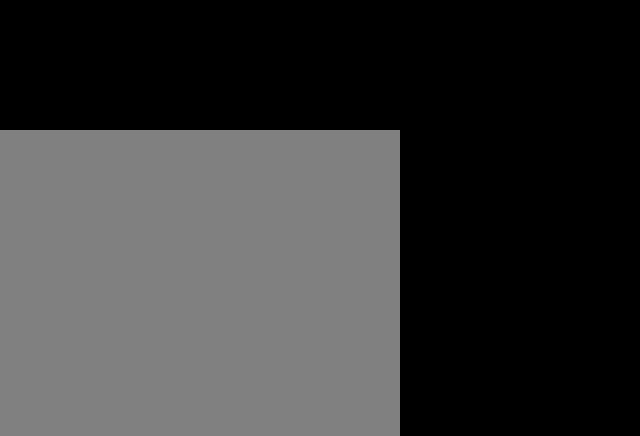

In [15]:
info = mne.io.read_info(raw_fname)
fig = mne.viz.plot_alignment(info, trans, subject='sample', dig=True,
                             subjects_dir=subjects_dir, verbose=True);
mlab.show()
mlab.savefig('coreg.jpg')
Image(filename='coreg.jpg', width=500)

In [ ]:
mlab.close('all')

## Compute Source Space

The source space defines the position of the candidate source locations.

The following code computes such a source space with an OCT-6 resolution.

In [11]:
mne.set_log_level('WARNING')
subject = 'sample'
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir,
                             add_dist=False)

In [12]:
src

<SourceSpaces: [<surface (lh), n_vertices=155407, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=156866, n_used=4098, coordinate_frame=MRI (surface RAS)>]>

``src`` contains two parts, one for the left hemisphere (4098 locations) and one for the right hemisphere (4098 locations).

In [14]:
fig = mne.viz.plot_alignment(info, trans, subject='sample', dig=False, src=src,
                             subjects_dir=subjects_dir, verbose=True, meg=False, eeg=False);
mlab.show()

Using outer_skin.surf for head surface.


In [16]:
mne.viz.plot_alignment(info, trans=trans, subject='sample',
                       src=src, subjects_dir=subjects_dir, dig=True,
                       surfaces=['head-dense', 'white'], coord_frame='meg')
mlab.show()

In [17]:
mlab.close()

AttributeError: 'NoneType' object has no attribute 'scene'

### Compute forward solution

We can now compute the forward solution.

To reduce computational load, we'll just compute a single layer BEM
(just inner skull) that can then be used for MEG (not EEG).

In [18]:
conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject='sample', ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

In [19]:
fwd = mne.make_forward_solution(raw_fname, trans=trans,
                                src=src, bem=bem,
                                meg=True, # include MEG channels
                                eeg=False, # include EEG channels
                                mindist=5.0, # ignore sources <= 5mm from inner skull
                                n_jobs=1) # number of jobs to run in parallel

In [22]:
fwd

<Forward | MEG channels: 306 | EEG channels: 0 | Source space: Surface with 7498 vertices | Source orientation: Free>

In [21]:
fwd['sol']['data'].shape

(306, 22494)

Or read the EEG/MEG file from disk

In [23]:
fwd = mne.read_forward_solution(fwd_fname)

In [24]:
fwd

<Forward | MEG channels: 306 | EEG channels: 60 | Source space: Surface with 7498 vertices | Source orientation: Free>

Convert to surface orientation for cortically constrained inverse modeling:

In [25]:
fwd = mne.convert_forward_solution(fwd, surf_ori=True)
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 366 sensors x 22494 dipoles


In [26]:
fwd

<Forward | MEG channels: 306 | EEG channels: 60 | Source space: Surface with 7498 vertices | Source orientation: Free>

Compute sensitivity maps:

In [27]:
grad_map = mne.sensitivity_map(fwd, ch_type='grad', mode='fixed')
mag_map = mne.sensitivity_map(fwd, ch_type='mag', mode='fixed')
eeg_map = mne.sensitivity_map(fwd, ch_type='eeg', mode='fixed')

# Show gain matrix a.k.a. leadfield matrix with sensitivy map

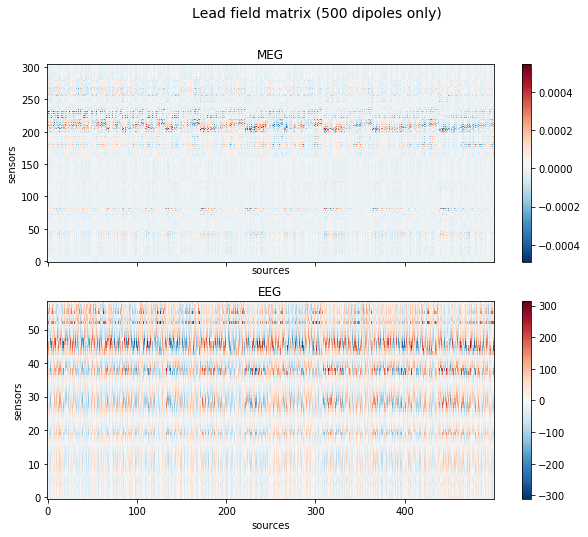

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

picks_meg = mne.pick_types(fwd['info'], meg=True, eeg=False)
picks_eeg = mne.pick_types(fwd['info'], meg=False, eeg=True)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)  
fig.suptitle('Lead field matrix (500 dipoles only)', fontsize=14)

for ax, picks, ch_type in zip(axes, [picks_meg, picks_eeg], ['meg', 'eeg']):
   im = ax.imshow(leadfield[picks, :500], origin='lower', aspect='auto', cmap='RdBu_r')
   ax.set_title(ch_type.upper())
   ax.set_xlabel('sources')
   ax.set_ylabel('sensors')
   plt.colorbar(im, ax=ax, cmap='RdBu_r')

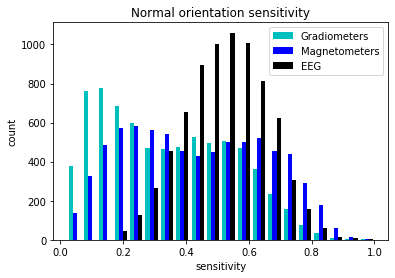

In [29]:
plt.hist([grad_map.data.ravel(), mag_map.data.ravel(), eeg_map.data.ravel()],
          bins=20, label=['Gradiometers', 'Magnetometers', 'EEG'],
         color=['c', 'b', 'k'])
plt.legend()
plt.title('Normal orientation sensitivity')
plt.xlabel('sensitivity')
plt.ylabel('count');

Uncomment the lines below to view

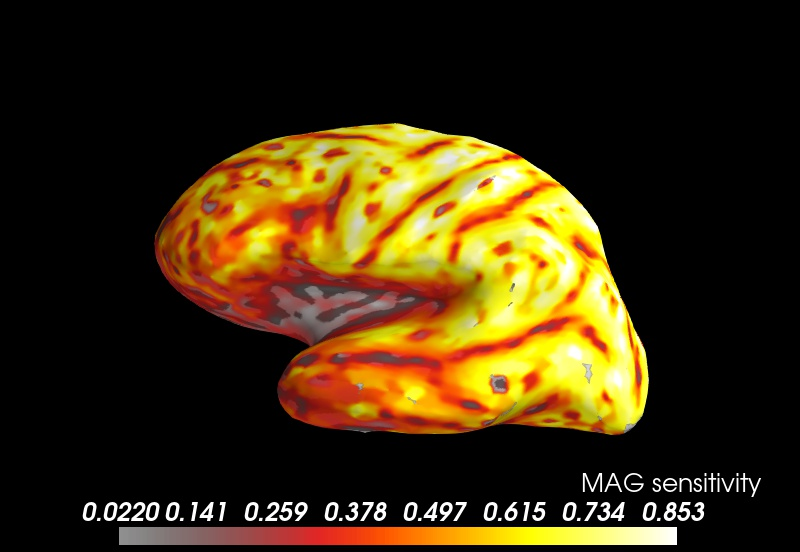

In [32]:
# enable correct backend for 3d plotting
%matplotlib qt
clim = dict(kind='percent', lims=(0.0, 50, 99), smoothing_steps=3)  # let's see single dipoles
brain = mag_map.plot(subject='sample', time_label='MAG sensitivity',
                     subjects_dir=subjects_dir, clim=clim, smoothing_steps=8);
view = 'lat'
brain.show_view(view)
brain.save_image('sensitivity_map_grad_%s.jpg' % view)
Image(filename='sensitivity_map_grad_%s.jpg' % view, width=400)

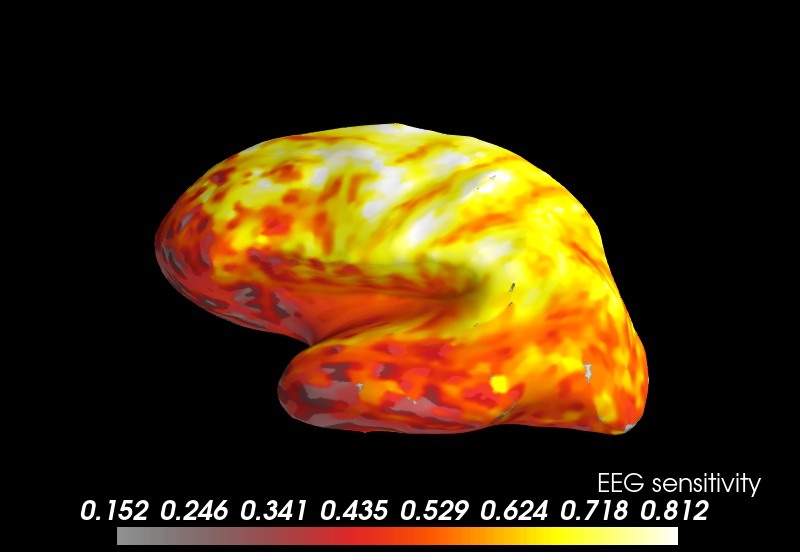

In [31]:
# enable correct backend for 3d plotting
%matplotlib qt
clim = dict(kind='percent', lims=(0.0, 50, 99), smoothing_steps=3)  # let's see single dipoles
brain = eeg_map.plot(subject='sample', time_label='EEG sensitivity',
                     subjects_dir=subjects_dir, clim=clim, smoothing_steps=8);
view = 'lat'
brain.show_view(view)
brain.save_image('sensitivity_map_eeg_%s.jpg' % view)
Image(filename='sensitivity_map_eeg_%s.jpg' % view, width=400)

## Exercise

Plot the sensitivity maps for EEG and compare it with the MEG. Can you justify the claims that:

- MEG is not sensitive to radial sources
- EEG is more sensitive to deep sources

How will the MEG sensitivity maps and histograms change if you use a free instead of a fixed orientation?

Try changing the `mode` parameter in `mne.sensitivity_map` accordingly.

Why don't we see any dipoles on the gyri?

# Visualizing field lines based on coregistration

In [33]:
from mne import read_evokeds
from mne.datasets import sample
from mne import make_field_map
data_path = sample.data_path()

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

subjects_dir = data_path + '/subjects'
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
trans_fname = data_path + '/MEG/sample/sample_audvis_raw-trans.fif'

In [34]:
make_field_map?

In [35]:
# If trans_fname is set to None then only MEG estimates can be visualized

condition = 'Left Auditory'
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
evoked = mne.read_evokeds(evoked_fname, condition=condition, baseline=(-0.2, 0.0))

# Compute the field maps to project MEG and EEG data to MEG helmet
# and scalp surface
maps = mne.make_field_map(evoked, trans=trans, subject='sample',
                      subjects_dir=subjects_dir, n_jobs=1)

# explore several points in time
field_map = evoked.plot_field(maps, time=.1);

In [ ]:
from mayavi import mlab
mlab.savefig('field_map.jpg')
from IPython.display import Image
Image(filename='field_map.jpg', width=800)